# <center>Admissions Forecasting </center>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
import prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data_2015_to_2020_scaling_with_end_date_mode_of_arrival_disposition.csv')
data['Admission Date']=pd.to_datetime(data['Admission Date'])
data.head()

,Admission Date,Discharge Date,Patient ID,Mode of Arrival,Disposition
0,2015-01-20,2015-02-09,24424196,Other,EXPIRED
1,2015-01-16,2015-01-28,57279250,Own Vehicle,ADMITTED
2,2015-01-15,2015-02-10,33220210,Own Vehicle,LEFT AGAINST MEDICAL ADVICE
3,2015-01-22,2015-01-29,82137812,Own Vehicle,EXPIRED
4,2015-01-15,2015-01-19,95712788,Own Vehicle,EXPIRED


In [3]:
data['year_admission_date']=data['Admission Date'].dt.strftime('%Y').astype(int)
data['month_admission_date']=data['Admission Date'].dt.strftime('%m').astype(int)
data[['year_admission_date','month_admission_date']]

,year_admission_date,month_admission_date
0,2015,1
1,2015,1
2,2015,1
3,2015,1
4,2015,1
...,...,...
134857,2020,12
134858,2020,12
134859,2020,12
134860,2020,12


In [4]:
# Train dataset with 5 years data: 2015, 2016, 2017, 2018 & 2019 
train_data = data[data['year_admission_date'].isin(range(2015, 2020))]
print(train_data.groupby('year_admission_date')['Patient ID'].count())
train_dataset = train_data.groupby('Admission Date')['Patient ID'].count().reset_index()
train_dataset.columns = ['Admission Date', 'Patient Count']
train_dataset.head()

year_admission_date
2015    22477
2016    22477
2017    22477
2018    22477
2019    22477
Name: Patient ID, dtype: int64


,Admission Date,Patient Count
0,2015-01-01,61
1,2015-01-02,75
2,2015-01-03,81
3,2015-01-04,65
4,2015-01-05,71


In [5]:
# Validation dataset with 6 months: 2020-01-01 to '2020-06-30'
validation_data = data[(data['year_admission_date'] == 2020) & (data['month_admission_date'] <= 6)]
print(validation_data.groupby('month_admission_date')['Patient ID'].count())
validation_dataset = (validation_data.groupby('Admission Date')['Patient ID'].count()).reset_index()
validation_dataset.columns = ['Admission Date', 'Patient Count']
validation_dataset.head()

month_admission_date
1    2158
2    1608
3    1961
4    1726
5    1765
6    2158
Name: Patient ID, dtype: int64


,Admission Date,Patient Count
0,2020-01-01,77
1,2020-01-02,72
2,2020-01-03,73
3,2020-01-04,75
4,2020-01-05,57


In [6]:
# Test dataset with 6 months: 2020-07-01 to '2020-12-31'
test_data = data[data['year_admission_date'] >= 2020]
print(test_data.groupby('year_admission_date')['Patient ID'].count())
test_dataset = test_data.groupby('Admission Date')['Patient ID'].count().reset_index()
test_dataset.columns = ['Admissions Date','Patient Count']
test_dataset.head()

year_admission_date
2020    22477
Name: Patient ID, dtype: int64


,Admissions Date,Patient Count
0,2020-01-01,77
1,2020-01-02,72
2,2020-01-03,73
3,2020-01-04,75
4,2020-01-05,57


### Auto Correlation Factor (ACF) and Partial Auto Correlation Factor (PACF)

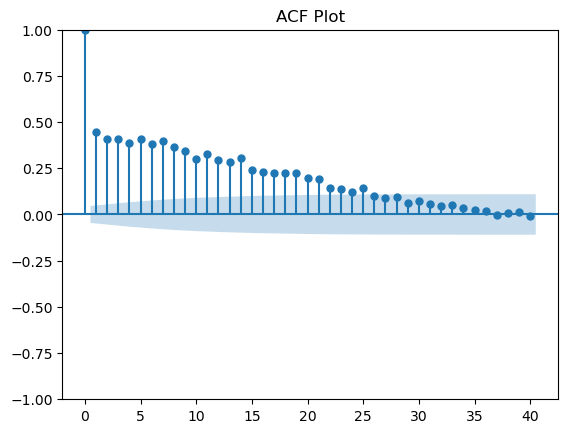

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


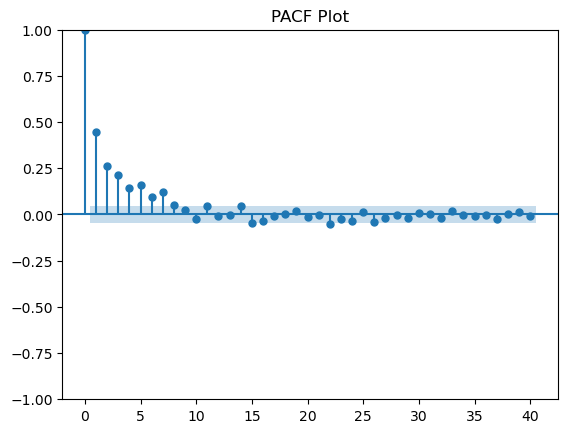

In [7]:
acf_plot = plot_acf(train_dataset['Patient Count'], lags=40)  

# Display the ACF plot
plt.title('ACF Plot')
plt.show()

pacf_plot = plot_pacf(train_dataset['Patient Count'], lags=40)  

# Display the ACF plot
plt.title('PACF Plot')
plt.show()

### Augmented Dicky Fuller Test

In [8]:
# Perform the ADF test
result = adfuller(train_dataset['Patient Count'])
adf_statistic = result[0]
p_value = result[1]

# Print ADF test results
print("ADF Statistic:", adf_statistic)
print("P-Value:", p_value)

ADF Statistic: -5.782832651765564
P-Value: 5.078839994884668e-07


### Determining values of p,d,q 

In [9]:
best_mse = float('inf')
best_order = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            order = (p, d, q)
            model = SARIMAX(train_dataset['Patient Count'], order=order)
            model_fit = model.fit(disp=0)
            predictions = model_fit.predict(start=len(train_dataset['Patient Count']), end=len(train_dataset['Patient Count']) + len(validation_dataset['Patient Count']) - 1)
            mse = mean_squared_error(validation_dataset['Patient Count'], predictions)
            if mse < best_mse:
                best_mse = mse
                best_order = order

print("Best MSE:", best_mse)
print("Best Order (p, d, q):", best_order)

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Best MSE: 112.65934065934066
Best Order (p, d, q): (0, 1, 0)


## Model: SARIMAX

In [10]:
# Fit ARIMA model to the training dataset
order = (0,1,0)  
model = SARIMAX(train_dataset['Patient Count'], order=order)
model_fit = model.fit(disp=0)

# Make predictions on the validation dataset
validation_predictions = model_fit.predict(start=len(train_dataset['Patient Count']), end=len(train_dataset['Patient Count']) + len(validation_dataset['Patient Count']) - 1)

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate performance metrics for the validation set
mse = mean_squared_error(validation_dataset['Patient Count'], validation_predictions)
mae = mean_absolute_error(validation_dataset['Patient Count'], validation_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(validation_dataset['Patient Count'], validation_predictions)
mape = mean_absolute_percentage_error(validation_dataset['Patient Count'], validation_predictions)

print("Validation MSE:", mse)
print("Validation MAE:", mae)
print("Validation RMSE:", rmse)
print("Validation R-squared:", r2)
print("Validation MAPE:", mape)

Validation MSE: 112.65934065934066
Validation MAE: 8.274725274725276
Validation RMSE: 10.614110450685006
Validation R-squared: -0.12243088365691279
Validation MAPE: 12.898262285804806


In [11]:
# Now, fit the best model (e.g., with the lowest validation MSE) on the full training dataset
best_model = SARIMAX(train_dataset['Patient Count'], order=best_order)
best_model_fit = best_model.fit(disp=0)

# Make predictions on the test dataset
test_predictions = best_model_fit.predict(start=len(train_dataset['Patient Count']) + len(validation_dataset['Patient Count']), end=len(train_dataset['Patient Count']) + len(validation_dataset['Patient Count']) + len(test_dataset['Patient Count']) - 1)

# Calculate performance metrics for the test set
mse = mean_squared_error(test_dataset['Patient Count'], test_predictions)
mae = mean_absolute_error(test_dataset['Patient Count'], test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_dataset['Patient Count'], test_predictions)
mape = mean_absolute_percentage_error(validation_dataset['Patient Count'], validation_predictions)

print("Validation MSE:", mse)
print("Validation MAE:", mae)
print("Validation RMSE:", rmse)
print("Validation R-squared:", r2)
print("Validation MAPE:", mape)

Validation MSE: 127.93939393939394
Validation MAE: 8.881542699724518
Validation RMSE: 11.311029747082886
Validation R-squared: -0.07140838874431932
Validation MAPE: 12.898262285804806


# To Be Worked On 

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)  # Specify the number of splits (folds)

best_mse = float('inf')
best_order = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            order = (p, d, q)
            mse_list = []

            for train_index, validation_index in tscv.split(train_dataset):
                train_fold = train_dataset.iloc[train_index]
                validation_fold = train_dataset.iloc[validation_index]

                # Define the SARIMAX model with the specific order
                model = SARIMAX(train_fold, order=order)
                model_fit = model.fit(disp=0)
                
                # Make predictions for the validation fold
                predictions = model_fit.predict(start=len(train_fold), end=len(train_fold) + len(validation_fold) - 1)
                
                mse = mean_squared_error(validation_fold, predictions)
                mse_list.append(mse)

            average_mse = np.mean(mse_list)

            if average_mse < best_mse:
                best_mse = average_mse
                best_order = order

print("Best MSE:", best_mse)
print("Best Order (p, d, q):", best_order)

### Model: SARIMAX

In [ ]:
# Fit ARIMA model to the training dataset
order = (2,1,0)  
model = SARIMAX(train_dataset, order=order)
model_fit = model.fit(disp=0)

# Make predictions on the validation dataset
validation_predictions = model_fit.predict(start=len(train_dataset), end=len(train_dataset) + len(validation_dataset) - 1)

# Calculate performance metrics for the validation set
mse = mean_squared_error(validation_dataset, validation_predictions)
mae = mean_absolute_error(validation_dataset, validation_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(validation_dataset, validation_predictions)

print("Validation MSE:", mse)
print("Validation MAE:", mae)
print("Validation RMSE:", rmse)
print("Validation R-squared:", r2)

# Now, fit the best model (e.g., with the lowest validation MSE) on the full training dataset
best_model = SARIMAX(train_dataset, order=best_order)
best_model_fit = best_model.fit(disp=0)

# Make predictions on the test dataset
test_predictions = best_model_fit.predict(start=len(train_dataset) + len(validation_dataset), end=len(train_dataset) + len(validation_dataset) + len(test_dataset) - 1)

# Calculate performance metrics for the test set
mse = mean_squared_error(test_dataset, test_predictions)
mae = mean_absolute_error(test_dataset, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test_dataset, test_predictions)

print("Test MSE:", mse)
print("Test MAE:", mae)
print("Test RMSE:", rmse)
print("Test R-squared:", r2)

In [ ]:
# Prepare a DataFrame with 'ds' for dates and 'y' for values
data = train_dataset

# Initialize the model
model = Prophet()

# Fit the model to the data
model.fit(data)

# Create a future DataFrame for forecasting
future = model.test_dataset(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create the model
model = ExponentialSmoothing(train_dataset, seasonal='add', seasonal_periods=12, trend='add', damped=True)

# Fit the model
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(len(validation_dataset))

# Evaluate the model
mse = mean_squared_error(validation_dataset, predictions)
print(mse)

In [ ]:
from tensorflow import keras

# Define an LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(n_steps, n_features)))
model.add(keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model with your time series data
model.fit(train_dataset['Admission Date'], train_y, epochs=100, batch_size=64, verbose=1)

# Make predictions
predictions = model.predict(validation_X)

# Evaluate the model
mse = mean_squared_error(validation_y, predictions)
print(mse)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create lag features
for lag in range(1, 4 + 1):
    train_dataset[f'lag_{lag}'] = train_dataset['y'].shift(lag)

# Drop missing values
train_dataset = train_dataset.dropna()

# Define features and target
X = train_dataset['Admission Date']
y = train_dataset['y']

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

# Create lag features for validation data
for lag in range(1, n_lags + 1):
    validation_dataset[f'lag_{lag}'] = validation_dataset['y'].shift(lag)

# Drop missing values
validation_dataset = validation_dataset.dropna()

# Predict
X_validation = validation_dataset[['lag_1', 'lag_2', ...]]
predictions = model.predict(X_validation)

# Evaluate the model
mse = mean_squared_error(validation_dataset['y'], predictions)
